In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.datasets import mnist
from keras.utils import to_categorical

from skimage.filters import gaussian
from skimage.util import random_noise
import random


newtest_images = np.load('test_data.npy')
newtest_labels = np.load('test_label.npy')

newtest_images = newtest_images.astype('float32')
newtest_images = newtest_images.reshape((39, 28, 28))
newtest_images = newtest_images.astype('float32')/255

newtest_images = newtest_images.reshape((39, 28, 28, 1))
c = 39
i=0
newtest_newlabels = [0]*40
while c:
  if(newtest_labels[i][0]==1.0):
    newtest_newlabels[i]=3
  elif(newtest_labels[i][1]==1.0):
    newtest_newlabels[i]=6
  elif(newtest_labels[i][2]==1.0):
    newtest_newlabels[i]=8
  c-=1
  i+=1
    
newtest_newlabels[39] = 9
newtest_newlabels = to_categorical(newtest_newlabels)
newtest_newlabels=np.delete(newtest_newlabels,[39,40],axis=0) 

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = 1-(train_images.astype('float32')/255)

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = 1-(test_images.astype('float32')/255)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

def randRange(a, b):
    return np.random.rand() * (b - a) + a

def randomGaussian(im):
    return gaussian(im, sigma=randRange(0, 1))

def randomNoise(im):
    var = randRange(0.001, 0.013)
    return random_noise(im, var=var)

def randomRescale(im):
  r1 = randRange(0.1,0.5)
  r2 = randRange(0.1,0.4)
  im1 = (im == 1) * r1
  im2 = (im < 0.5) * (im+r2)
  im = im1 + im2
  return im

def randomRescale2(im):
  r=randRange(0.5,0.8)
  im = im+(1-im)*r
  return im

def augment(im, Steps= [randomGaussian, randomNoise, randomRescale, randomRescale2]):
    i= np.random.randint(4)
    step = Steps[i]
    im = step(im)
    return im

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

# 데이터 제너레이터

from keras.preprocessing.image import ImageDataGenerator 
    
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='reflect',
    preprocessing_function=augment,
    zoom_range=0.5)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_datagen.flow(train_images, train_labels, batch_size=256),
                    steps_per_epoch=512, epochs=30, validation_data=(newtest_images,newtest_newlabels))

test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

newtest_loss, newtest_acc = model.evaluate(newtest_images, newtest_newlabels)
newtest_acc
model.save('mnist_cnn_model.h5')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)               

count= 11


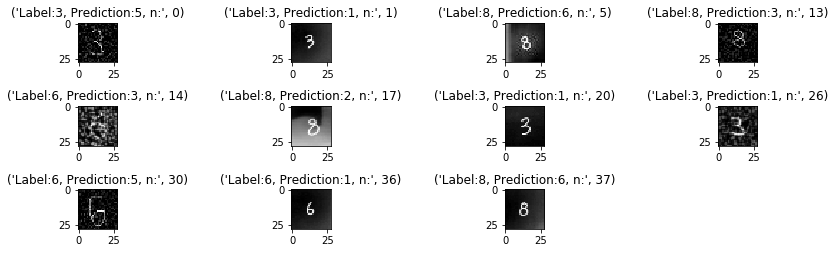

In [5]:
import random
import matplotlib.pyplot as plt

predicted_result = model.predict(newtest_images)
predicted_labels = np.argmax(predicted_result, axis=1)

test_labels = np.argmax(newtest_newlabels, axis=1)

wrong_result = []
count=0

for n in range(0, len(test_labels)):
    if predicted_labels[n] != test_labels[n]:
      count=count+1
      wrong_result.append(n)
      
print("count=",count)

count = 0
nrows = 7
ncols = 4

plt.figure(figsize=(12,8))

for n in wrong_result:
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(newtest_images[n].reshape(28, 28), cmap='Greys', interpolation='nearest')
    tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n]) + ", n:",n
    plt.title(tmp)

plt.tight_layout()
plt.show()